In [4]:
from matplotlib import pyplot as plt
import torchaudio as ta
import torch
import sys
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torchaudio.compliance.kaldi as kaldi
from utils import *

class CustomDataset(Dataset):
    """ PATH = [dir1, dir2 , ...] """
    def __init__(self, path_dir_nb, path_dir_wb, seg_len, iscodec=True, mode="train"):
        assert isinstance(path_dir_nb, list), "PATH must be a list"

        self.seg_len = seg_len
        self.mode = mode
        
        paths_wav_wb = []
        paths_wav_nb = []
        for i in range(len(path_dir_nb)):
            self.path_dir_nb = path_dir_nb[i]
            self.path_dir_wb = path_dir_wb[i]
            paths_wav_wb.extend(get_audio_paths(self.path_dir_wb, file_extensions='.wav'))
            paths_wav_nb.extend(get_audio_paths(self.path_dir_nb, file_extensions='.wav'))

        print(f"LR {len(paths_wav_nb)} and HR {len(paths_wav_wb)} file numbers loaded!")

        if len(paths_wav_wb) != len(paths_wav_nb):
            sys.exit(f"Error: LR {len(paths_wav_nb)} and HR {len(paths_wav_wb)} file numbers are different!")

        self.filenames = [(path_wav_wb, path_wav_nb) for path_wav_wb, path_wav_nb in zip(paths_wav_wb, paths_wav_nb)]
        print(f"{mode}: {len(self.filenames)} files loaded")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        path_wav_wb, path_wav_nb = self.filenames[idx]

        wav_nb, sr_nb = ta.load(path_wav_nb)
        wav_wb, sr_wb = ta.load(path_wav_wb)

        # print(wav_nb.shape)
        wav_wb = wav_wb.view(1, -1)
        wav_nb = wav_nb.view(1, -1)

        if self.seg_len > 0 and self.mode == "train":
            duration = int(self.seg_len * 16000)  # Assuming 16kHz sample rate
            sig_len = wav_wb.shape[-1]

            t_start = np.random.randint(low=0, high=np.max([1, sig_len - duration - 2]), size=1)[0]
            if t_start % 2 == 1:
                t_start -= 1
            t_end = t_start + duration

            wav_nb = wav_nb.repeat(1, t_end // sig_len + 1)[..., t_start:t_end]
            wav_wb = wav_wb.repeat(1, t_end // sig_len + 1)[..., t_start:t_end]

            wav_nb = self.ensure_length(wav_nb, sr_nb * self.seg_len)
            wav_wb = self.ensure_length(wav_wb, sr_wb * self.seg_len)

        elif self.mode == "val":
            min_len = min(wav_wb.shape[-1], wav_nb.shape[-1])
            wav_nb = self.ensure_length(wav_nb, min_len)
            wav_wb = self.ensure_length(wav_wb, min_len)

        else:
            sys.exit(f"unsupported mode! (train/val)")

        # Compute fbank using Kaldi
        fbank_nb = self.compute_fbank(wav_nb, sr_nb)
        fbank_wb = self.compute_fbank(wav_wb, sr_wb)

        # Normalize the fbank
        fbank_nb = self.normalize_fbank(fbank_nb)
        fbank_wb = self.normalize_fbank(fbank_wb)

        # return wav_nb, wav_wb, fbank_nb, fbank_wb, get_filename(path_wav_wb)[0]
        return fbank_wb, get_filename(path_wav_wb)[0]

    @staticmethod
    def ensure_length(wav, target_length):
        if wav.shape[1] < target_length:
            pad_size = target_length - wav.shape[1]
            wav = F.pad(wav, (0, pad_size))
        elif wav.shape[1] > target_length:
            wav = wav[:, :target_length]
        return wav

    @staticmethod
    def compute_fbank(wav, sample_rate, num_mel_bins=128, target_len=1024):
        """Compute the fbank using Kaldi."""
        wav = wav - wav.mean()
        fbank = kaldi.fbank(wav, htk_compat=True, sample_frequency=sample_rate, use_energy=False, 
                            window_type='hanning', num_mel_bins=num_mel_bins, dither=0.0, frame_shift=10)
        
        # Ensure the fbank has the target length
        n_frames = fbank.shape[0]
        p = target_len - n_frames
        if p > 0:
            fbank = F.pad(fbank, (0, 0, 0, p), "constant", 0)
        elif p < 0:
            fbank = fbank[:target_len, :]
        return fbank

    @staticmethod
    def normalize_fbank(fbank):
        """Normalize the fbank based on predefined mean and std."""
        norm_mean = -4.2677393
        norm_std = 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def display_fbank(self, bank, minmin=None, maxmax=None, colorbar=False):
        #print(bank.shape, bank.min(), bank.max())
        #plt.figure(figsize=(18, 6))
        plt.figure(figsize=(20, 4))
        plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
        if colorbar: plt.colorbar()
        #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
        #S_db = bank.T.numpy()
        #plt.figure()
        #librosa.display.specshow(10*bank.T.numpy())
        #plt.colorbar()
        plt.show()

LR 51947 and HR 51947 file numbers loaded!
train: 51947 files loaded


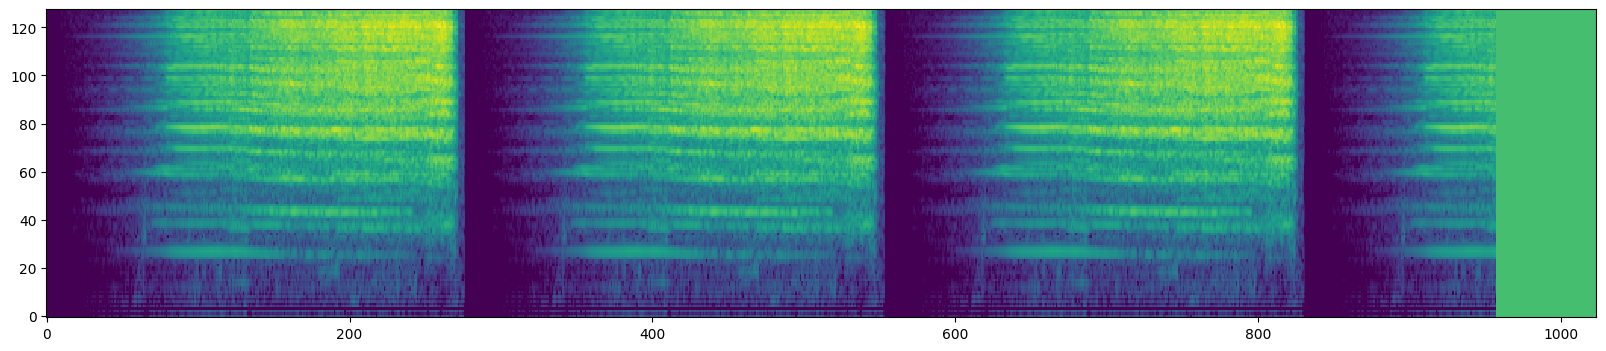

10340_16kHz


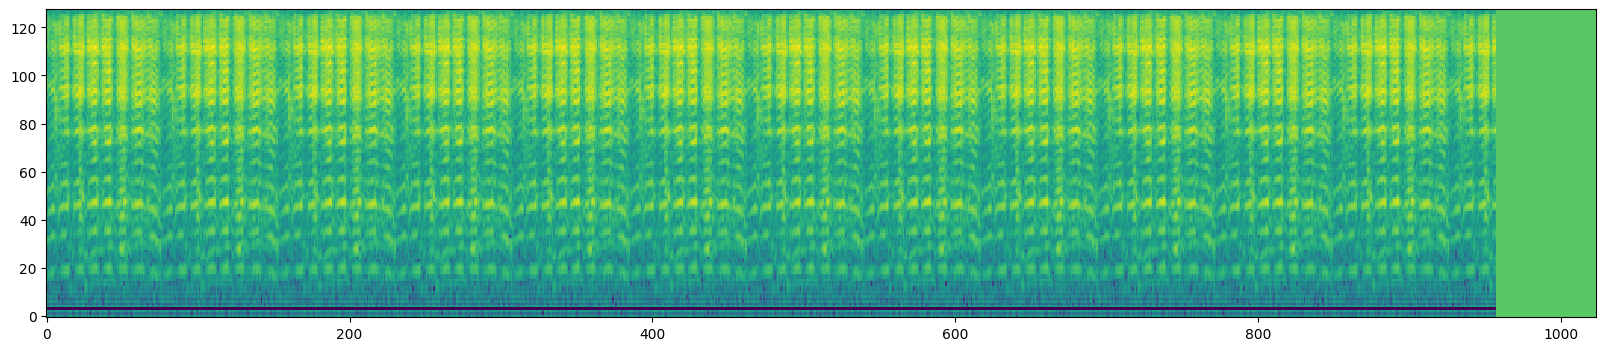

103410_16kHz


In [28]:
from IPython.display import Audio, display

dataset = CustomDataset(

    path_dir_wb=[ "/mnt/hdd/Dataset/FSD50K_16kHz", 
                "/mnt/hdd/Dataset/MUSDB18_HQ_16kHz_mono"],
    path_dir_nb=["/mnt/hdd/Dataset/FSD50K_16kHz_codec",
                 "/mnt/hdd/Dataset/MUSDB18_MP3_8k"],
                 
    seg_len=9.6,
    mode='train'
)

for i in np.arange(501,503):
    fbbank, name = dataset[i]
    # nb, wb, nbbank, fbbank, name = dataset[i]
    dataset.display_fbank(fbbank, )
    # print(nb.shape, wb.shape, fbbank.shape)
    # display(Audio(wb, rate=16000))
    print(name)

In [29]:
import torch
import os
import torch.nn as nn
from einops import rearrange
from AudioMAE.models_mae import mae_vit_base_patch16


""" 85M Feature Extractor """
class AudioMAEEncoder(nn.Module):
    def __init__(self, img_size=(1024, 128), audio_exp=True, in_chans=1, visualize=False):
        super(AudioMAEEncoder, self).__init__()
        
        self.visualize = visualize
        # Load MAE_VIT base model
        self.model = mae_vit_base_patch16(img_size=img_size, audio_exp=audio_exp, in_chans=in_chans)
        
        # Delete decoder modules
        del self.model.decoder_embed
        del self.model.decoder_blocks
        del self.model.decoder_norm
        del self.model.decoder_pred
        del self.model.log_softmax
        del self.model.decoder_pos_embed
        
        self.model.forward = self.model.forward_encoder_no_mask

        # Load weights
        self.weight_path = "/home/woongjib/Projects/BESSL/weights/pretrained_AS2M.pth"

    def load_weights(self):
        checkpoint_dict = torch.load(self.weight_path, map_location='cpu')
        model_dict = self.model.state_dict()
        
        # Filter out unnecessary keys and load only matching keys
        filtered_dict = {k: v for k, v in checkpoint_dict['model'].items() if k in model_dict}
        unfiltered = {k: v for k, v in checkpoint_dict['model'].items() if k not in model_dict}

        if self.visualize:
            # Print unused parameters
            print("\n ****** Unused Parameters ******")
            for k in unfiltered:
                print(k, end='\n')

            print("\n ****** Used Parameters ******")
            for k in filtered_dict:
                print(k, end='\n')

        # Update the model's state dict with the filtered checkpoint weights
        model_dict.update(filtered_dict)
        self.model.load_state_dict(model_dict)
        print(f"*** Weights loaded from {os.path.basename(self.weight_path)} ***")

    def forward(self, x, patch_len=64, freq_bin=8):
        x = self.model(x)
        # Delete CLS Token
        x = x[:, 1:, :]
        x = rearrange(x, 'b (t_p f_p) d -> b t_p f_p d', f_p=8)
        # Output Shape: B x T x F x D

        # len = 2 sec -> 200 // 16
        x = x[:,:patch_len,:,] # B x T x 8 x D
        x = rearrange(x, 'b t f d -> b t (f d)')

        return x 

# Example
if __name__ == "__main__":
    data = torch.rand(10, 1, 1024, 128)
    model = AudioMAEEncoder(visualize=False)
    model.load_weights()

    out = model(data, patch_len=64)
    print(out.shape)
    
    from torchinfo import summary
    # print(summary(model, input_data=data))

*** Weights loaded from pretrained_AS2M.pth ***
torch.Size([10, 64, 6144])


In [30]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
print(len(dataloader))
for i in dataloader:
    spec, name = i
    print(spec.shape)
    break


406


torch.Size([128, 1024, 128])


In [35]:
embeddings = torch.rand(1000, 6144)

for i in range(8):
    i = 768 * i
    print(i)

0
768
1536
2304
3072
3840
4608
5376


In [43]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor, WavLMModel, AutoModel, AutoProcessor
import torch
from sklearn.cluster import MiniBatchKMeans, KMeans
import pickle
from einops import rearrange
import gc
from tqdm import tqdm
import torch.nn.functional as F

def run_kmeans_and_save(embeddings, n_clusters_list, model_name='MAE' ):
    num_patches = 8  # Assuming 8 patches
    patch_size = 768  # Each patch has 768 dimensions

    for n_clusters in n_clusters_list:
        print(f"Running k-means for {n_clusters} clusters...")

        patch_kmeans_models = []  # To store k-means models for each patch

        for idx in range(num_patches):
            # Extract the patch-specific embeddings
            patch_embeddings = embeddings[:, idx * patch_size:(idx + 1) * patch_size]
            
            # Initialize and fit k-means for the current patch
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, verbose=1)
            patch_embeddings = patch_embeddings.cpu()
            kmeans.fit(patch_embeddings.numpy())

            # Store the k-means model
            patch_kmeans_models.append(kmeans)

            print(f"\n Patch {idx} - Labels shape for {n_clusters} clusters:", kmeans.labels_.shape)

        # Save the k-means models for all patches in one file
        save_path = f"kmeans/K{n_clusters}_{model_name}.pkl"
        with open(save_path, 'wb') as file:
            # Length 8 Kmeans Codebook List
            pickle.dump(patch_kmeans_models, file)

        print(f"\t Saved k-means models for {n_clusters} clusters to {save_path}")

# Dataloader with length 406 (51968 samples)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
# subdataset = SmallDataset(dataloader, 300)
# dataloader = DataLoader(subdataset, batch_size=128, shuffle=True)

model = AudioMAEEncoder(visualize=False).eval().cuda()

embs = []
for spec, name in tqdm((dataloader), desc="Extracting embeddings"):
    with torch.no_grad():
        spec = spec.cuda()
        features = model(spec.unsqueeze(1))
        embs.append(features)

data_tensor = torch.cat(embs, dim=0)
print(f"data tensor shape:", data_tensor.shape)
# B x 64 x 6144

embeddings = data_tensor.reshape(-1, data_tensor.shape[-1])
print(f"embeddings shape:", embeddings.shape)
# FRAMES x 6144 (8 patches)

run_kmeans_and_save(embeddings,[64,4,128])


Extracting embeddings: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


data tensor shape: torch.Size([300, 64, 6144])
embeddings shape: torch.Size([19200, 6144])
Running k-means for 1 clusters...
Initialization complete
Iteration 0, inertia 3987697.25.
Iteration 1, inertia 2613398.75.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5917765.0.
Iteration 1, inertia 2613399.0.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3575490.0.
Iteration 1, inertia 2613398.75.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3661329.0.
Iteration 1, inertia 2613398.75.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3824167.25.
Iteration 1, inertia 2613399.0.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3824167.25.
Iteration 1, inertia 2613399.0.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4749484.0.
Iteration

: 